# PRACTICA 6 - MORFOLOGÍA

In [4]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as plti

from skimage.feature import canny

%matplotlib inline

In [5]:
M_YIQ = np.array([[0.299, 0.587, 0.114],
                  [0.595716, -0.274453, -0.321263],
                  [0.211456, -0.522591, 0.311135]])

M_RGB = np.array([[1, 0.9563, 0.6210],
                  [1, -0.2721, -0.6474],
                  [1, -1.1070, 1.7046]])

def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

def rgb2yiq(img):
    return apply_matrix(img, M_YIQ)

def yiq2rgb(img):
    return apply_matrix(img, M_RGB)
 

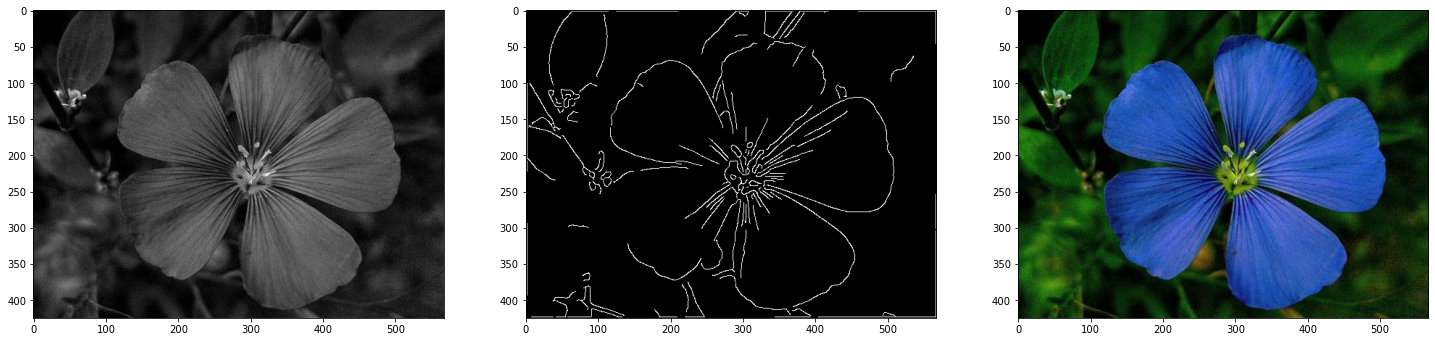

In [6]:
img_rgb = imageio.imread("FlorAzul.png")[:,:,0:3]/255
img_gray = rgb2yiq(imageio.imread("FlorAzul.png")[:,:,0:3]/255)[:,:,0]
img_bin = canny(img_gray, sigma = 2)
#img_bin = canny((rgb2yiq(img_rgb)[:,:,0]),sigma=1)

fig, axes = plt.subplots(1, 3, figsize=(25,30))
axes[0].imshow(img_gray, 'gray')
axes[1].imshow(img_bin, 'gray')
axes[2].imshow(img_rgb)

In [7]:
#Funciones
def morph_op(img, se, fcn): 
    '''Implements a general morphologic operation.'''
    se_flip = np.flip(se, axis=[0,1])
    rk, ck = se_flip.shape
    img_pad = np.pad(img, ((rk//2, rk//2), (ck//2, ck//2)), 'edge')
    img_out = np.zeros(img.shape)
    for r,c in np.ndindex(img.shape):
        img_out[r,c] = fcn(img_pad[r:r+rk,c:c+ck][se_flip])
    return img_out

def morph_multiband(img, se, argfcn):
    '''Implements a general morphologic operation on a mutichannel image based on the first channel.'''
    se_flip = np.flip(se, axis=[0,1])
    rk, ck = se_flip.shape
    img_pad = np.pad(img, ((rk//2, rk//2), (ck//2, ck//2), (0,0)), 'edge')
    img_out = np.zeros(img.shape)
    rse, cse = np.where(se_flip)
    for r,c in np.ndindex(img.shape[:2]):
        loc = argfcn(img_pad[r:r+rk,c:c+ck,0][se_flip])
        img_out[r,c] = img_pad[r+rse[loc],c+cse[loc]]
    return img_out

def morph_color(img, se, argfcn):
    '''Applies a morphological operation to a color image based on the 
    Y-channel.
    '''
    img2 = (rgb2yiq(img)[:, :, 0])[:, :, np.newaxis]
    img2 = np.concatenate((img2, img),axis=2)
    result = morph_multiband(img2, se, argfcn)[:, :, 1:]
    return result

#DILATAR
def im_dilate(img, se):
    '''Morphological dilation for binary, grayscale or RGB images.'''
    if img.ndim == 2:
        return morph_op(img, se, np.max) #np.max me devuelve el valor máximo del elemento estructurante que hay en la imagen
    else:
        return morph_color(img, se, np.argmax)  #np.argmax me devuelve la posición donde se encuentra el pixel máximo

#EROSIONAR
def im_erosion(img, se):
    if img.ndim == 2:
        return morph_op(img, se, np.min) #np.min me devuelve el valor minimo del elemento estructurante que hay en la imagen
    else:
        return morph_color(img, se, np.argmin)  #np.argmin me devuelve la posición donde se encuentra el pixel minimo

#Funcion para encontrar la posicion de la mediana
def mediana(M):
    aux=np.argsort(M) #np.argsort ordena de menor a mayor pero me da el indice
    aux=aux[len(M)//2] #busco el del medio
    return aux

#FILTRO DE MEDIANA
def im_mediana(img, se):
    if img.ndim == 2:
        return morph_op(img, se, np.median)
    else:
        return morph_color(img, se, mediana)
    
#Operaciones de suma/resta entre erosión y dilatación    
def borde_externo(img, se):
    return (im_dilate(img,se) - img)

def borde_interno(img, se):
    return (img - im_erosion(img, se))

def gradiente(img, se):
    return (im_dilate(img,se) - im_erosion(img, se))

#Operaciones concatenando dilatación y erosión
def apertura(img, se):
    return (im_dilate(im_erosion(img, se), se)) #hace una dilatacion a lo erosionado

def cierre(img,se):
    return (im_erosion(im_dilate(img, se), se)) #hace una erosion a lo dilatado
 
def top_hat(img,se):
    return (img-apertura(img, se))

def bottom_hat(img,se):
    return (cierre(img, se)-img)

#Operaciones concatenando cierre y apertura
def OC(img,se):
    return (cierre(apertura(img,se), se)) #se hace un cierre a lo que se aplico apertura

def CO(img,se):
    return (apertura(cierre(img,se), se)) #se hace una aprtura a lo que se aplico cierre


# Operaciones morfológicas

Definir los siguientes elementos estructurantes (structuring elements), para luego aplicar operaciones morfológicas. 
Los elementos estructurantes son similares a un kernel convolucional pero el tipo de dato es booleano (True o False). 

1. Box
2. Circle

Utilizando las funciones de ejemplo implementar las siguientes operaciones morfológicas, tanto para escala de grises como para RGB. Para RGB realizar la operación en base a los valores del canal Y:

Operaciones básicas (nivel 1):

1. Dilatación
2. Erosión
3. Filtro de mediana

Operaciones de suma/resta entre erosión y dilatación:

4. Borde externo (Dilatacion - imagen)
5. Borde interno (imagen - Erosión)
6. Gradiente (Dilatación - Erosión)

Operaciones concatenando dilatación y erosión (nivel 2):

7. Apertura (Erosión + Dilatación)
8. Cierre (Dilatación + Erosión)
9. Top-hat (imagen - Apertura)
10. Bottom-hat (Cierre - imagen)

Operaciones concatenando cierre y apertura (nivel 3):

11. OC (Open + Close)
12. CO (Close + Open)

EXTRA:

13. Segmentación del iris del ojo
14. Extracción de texto

BOX & CIRCLE

In [8]:
#-----BOX-----
N=3
se_box = np.ones((N,N), dtype=bool)
print("Elemento estructural box:\n" + str(se_box))

#-----CIRCLE-----
se_circle = np.array([[0,1,0],
                      [1,1,1],
                      [0,1,0]])
se_circle = se_circle > 0
print("\nElemento estructural circle:\n" + str(se_circle))


Elemento estructural box:
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]

Elemento estructural circle:
[[False  True False]
 [ True  True  True]
 [False  True False]]


DILATACION

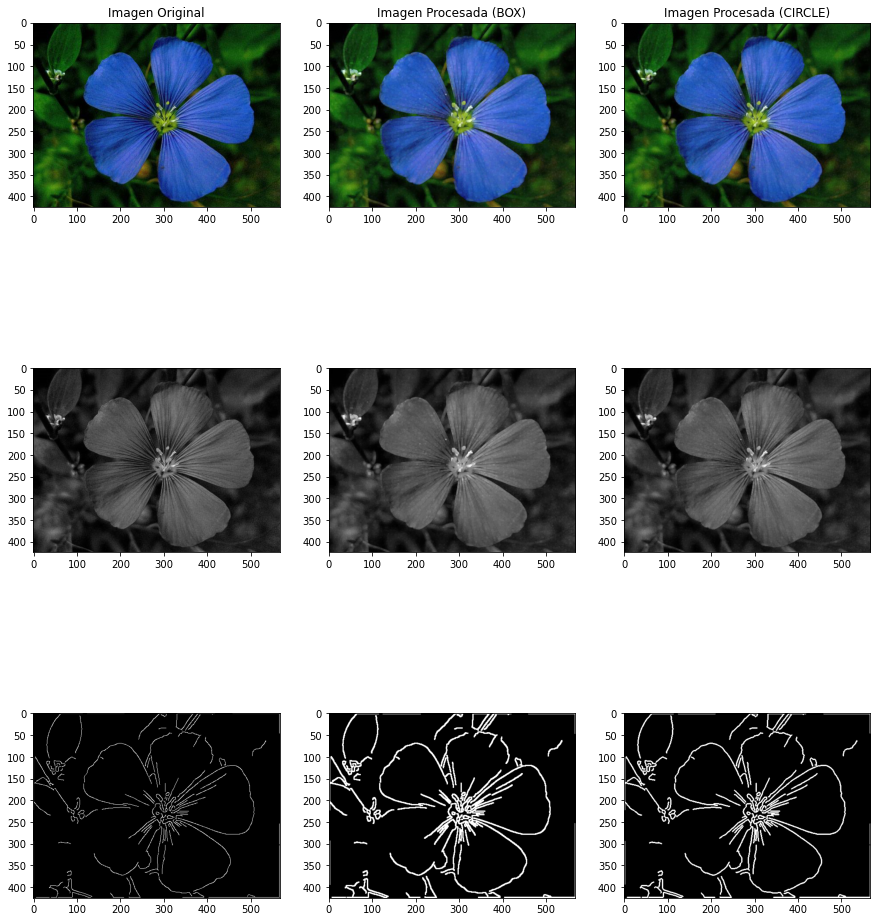

In [9]:

#Llamado a funciones de dilatacion con el elemento estructural box
gray_dil = im_dilate(img_gray,se_box)
bin_dil = im_dilate(img_bin,se_box)
rgb_dil = im_dilate(img_rgb,se_box)

#Llamado a funciones de dilatacion con el elemento estructural circle
gray_dil_c = im_dilate(img_gray,se_circle)
bin_dil_c = im_dilate(img_bin,se_circle)
rgb_dil_c = im_dilate(img_rgb,se_circle)

#graficos
fig, axes = plt.subplots(3, 3, figsize=(15,18))
axes[0,0].set_title('Imagen Original')
axes[0,1].set_title('Imagen Procesada (BOX)')
axes[0,2].set_title('Imagen Procesada (CIRCLE)')
axes[0,0].imshow(img_rgb)
axes[0,1].imshow(rgb_dil)
axes[0,2].imshow(rgb_dil_c)
axes[1,0].imshow(img_gray, 'gray')
axes[1,1].imshow(gray_dil, 'gray')
axes[1,2].imshow(gray_dil_c, 'gray')
axes[2,0].imshow(img_bin, 'gray')
axes[2,1].imshow(bin_dil, 'gray')
axes[2,2].imshow(bin_dil_c, 'gray')



EROSION

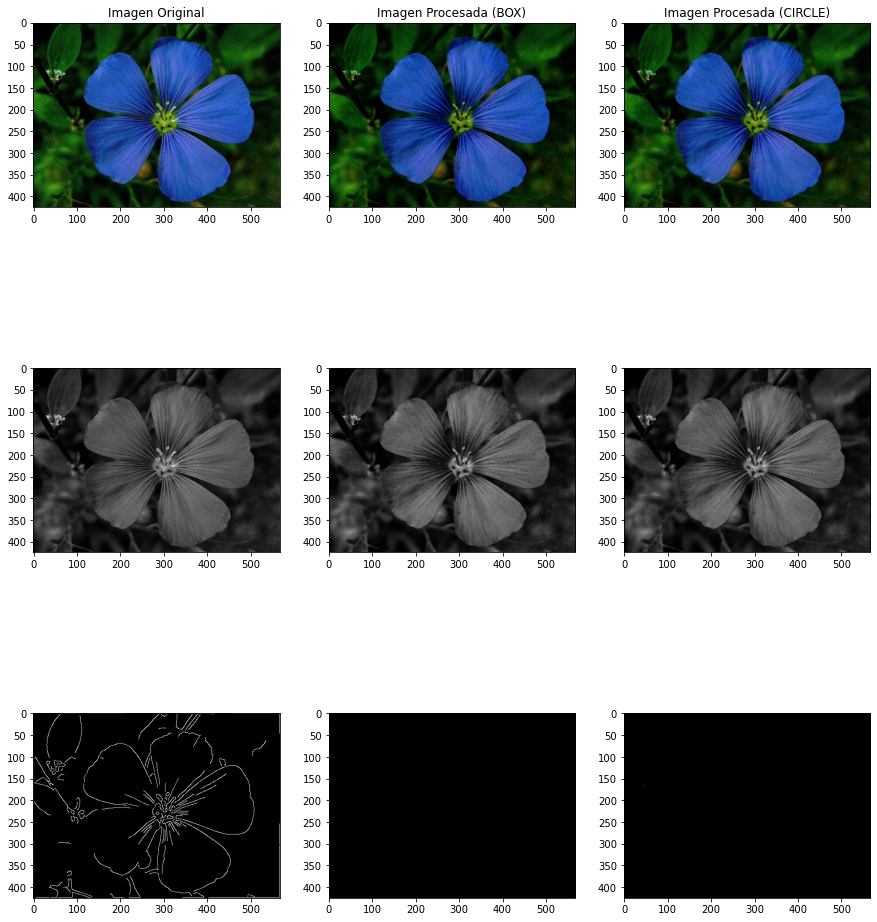

In [10]:

#Llamado a funciones de erosion con el elemento estructural box
gray_ero = im_erosion(img_gray,se_box)
bin_ero = im_erosion(img_bin,se_box)
rgb_ero = im_erosion(img_rgb,se_box)

#Llamado a funciones de erosion con el elemento estructural circle
gray_ero_c = im_erosion(img_gray,se_circle)
bin_ero_c = im_erosion(img_bin,se_circle)
rgb_ero_c = im_erosion(img_rgb,se_circle)

#graficos aplicando erosion
fig, axes = plt.subplots(3, 3, figsize=(15,18))
axes[0,0].set_title('Imagen Original')
axes[0,1].set_title('Imagen Procesada (BOX)')
axes[0,2].set_title('Imagen Procesada (CIRCLE)')
axes[0,0].imshow(img_rgb)
axes[0,1].imshow(rgb_ero)
axes[0,2].imshow(rgb_ero_c)
axes[1,0].imshow(img_gray, 'gray')
axes[1,1].imshow(gray_ero, 'gray')
axes[1,2].imshow(gray_ero_c, 'gray')
axes[2,0].imshow(img_bin, 'gray')
axes[2,1].imshow(bin_ero, 'gray')
axes[2,2].imshow(bin_ero_c, 'gray')



MEDIANA

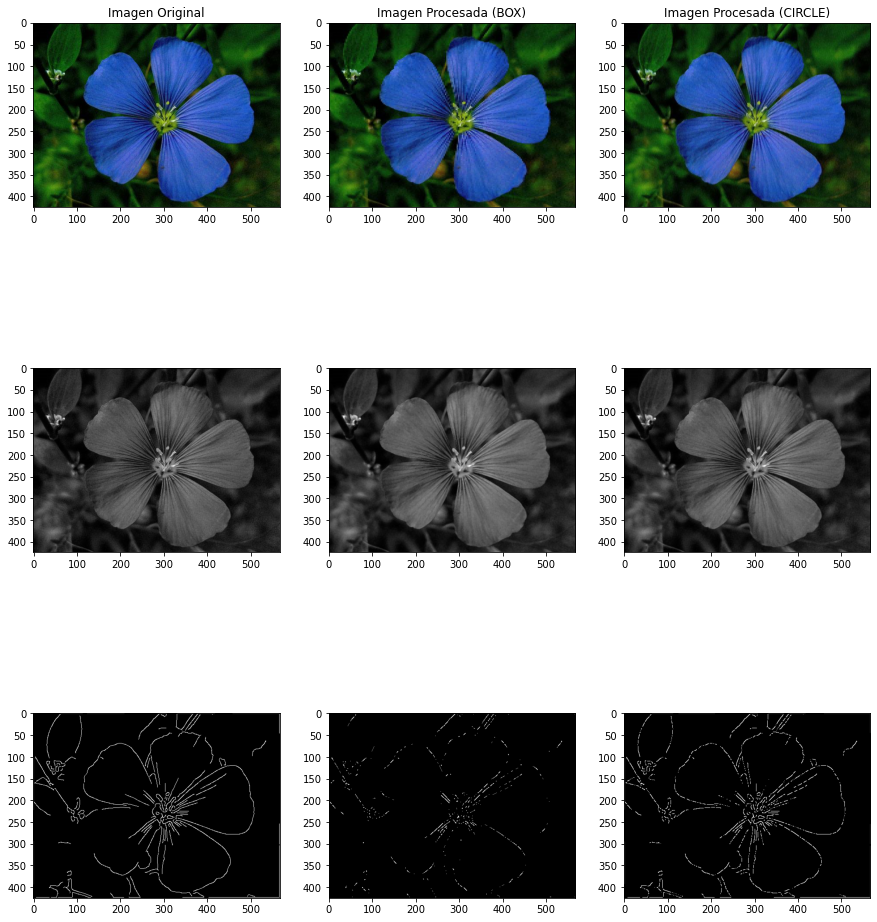

In [26]:

#Llamado a filtro de mediana con el elemento estructural box
gray_med = im_mediana(img_gray,se_box)
bin_med = im_mediana(img_bin,se_box)
rgb_med = im_mediana(img_rgb,se_box)

#Llamado a filtro de mediana con el elemento estructural circle
gray_med_c = im_mediana(img_gray,se_circle)
bin_med_c = im_mediana(img_bin,se_circle)
rgb_med_c = im_mediana(img_rgb,se_circle)

#graficos aplicando filtro de mediana
fig, axes = plt.subplots(3, 3, figsize=(15,18))
axes[0,0].set_title('Imagen Original')
axes[0,1].set_title('Imagen Procesada (BOX)')
axes[0,2].set_title('Imagen Procesada (CIRCLE)')
axes[0,0].imshow(img_rgb)
axes[0,1].imshow(rgb_med)
axes[0,2].imshow(rgb_med_c)
axes[1,0].imshow(img_gray, 'gray')
axes[1,1].imshow(gray_med, 'gray')
axes[1,2].imshow(gray_med_c, 'gray')
axes[2,0].imshow(img_bin, 'gray')
axes[2,1].imshow(bin_med, 'gray')
axes[2,2].imshow(bin_med_c, 'gray')



BORDE EXTERNO

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


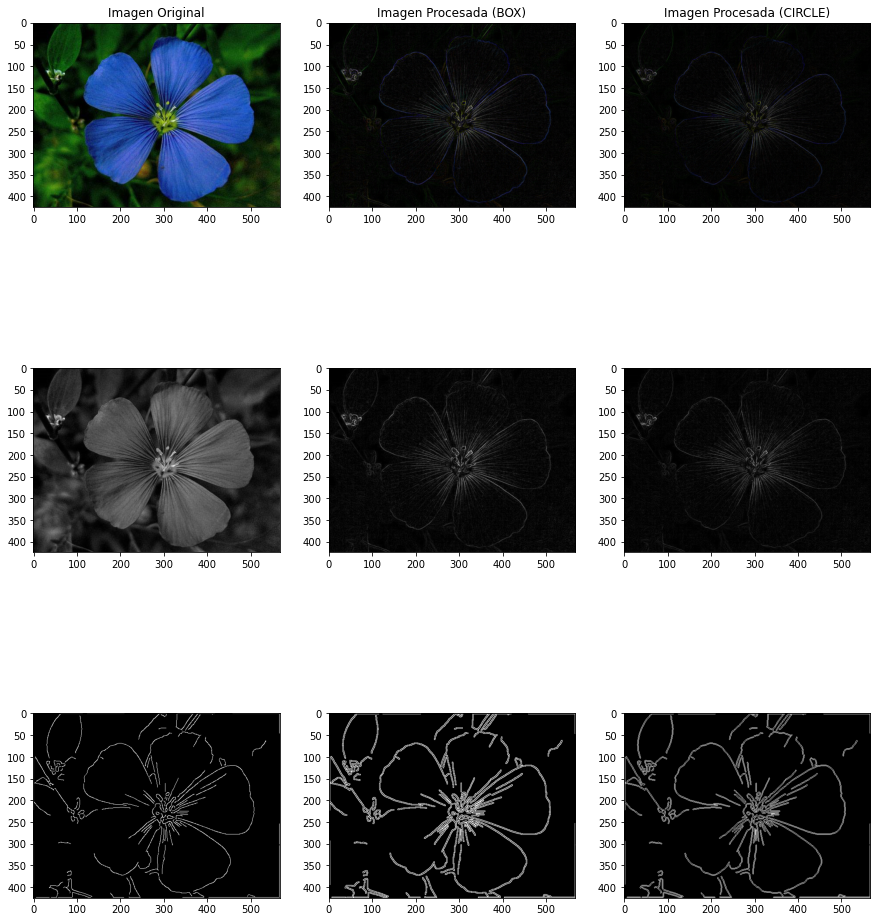

In [11]:

#Llamado a funcion borde externo con el elemento estructural box
gray_ext = borde_externo(img_gray,se_box)
bin_ext = borde_externo(img_bin,se_box)
rgb_ext = borde_externo(img_rgb,se_box)

#Llamado a funcion borde externo con el elemento estructural circle
gray_ext_c = borde_externo(img_gray,se_circle)
bin_ext_c = borde_externo(img_bin,se_circle)
rgb_ext_c = borde_externo(img_rgb,se_circle)

#graficos aplicando deteccion de borde externo
fig, axes = plt.subplots(3, 3, figsize=(15,18))
axes[0,0].set_title('Imagen Original')
axes[0,1].set_title('Imagen Procesada (BOX)')
axes[0,2].set_title('Imagen Procesada (CIRCLE)')
axes[0,0].imshow(img_rgb)
axes[0,1].imshow(rgb_ext)
axes[0,2].imshow(rgb_ext_c)
axes[1,0].imshow(img_gray, 'gray')
axes[1,1].imshow(gray_ext, 'gray')
axes[1,2].imshow(gray_ext_c, 'gray')
axes[2,0].imshow(img_bin, 'gray')
axes[2,1].imshow(bin_ext, 'gray')
axes[2,2].imshow(bin_ext_c, 'gray')

BORDE INTERNO

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


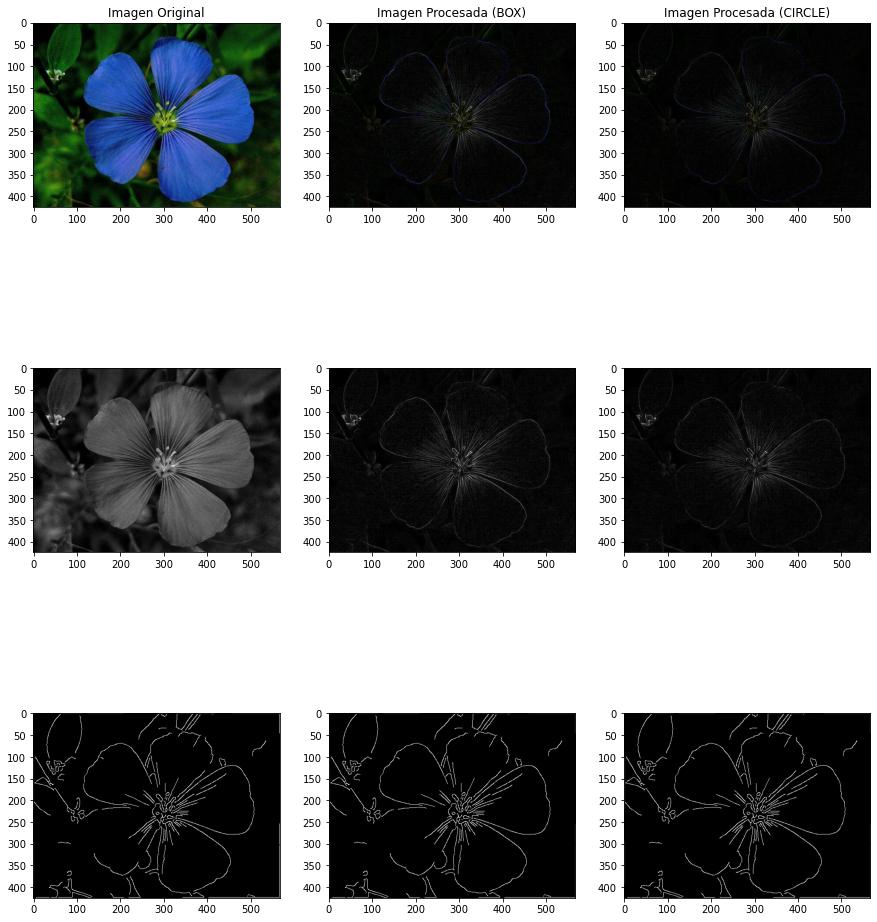

In [12]:

#Llamado a funcion borde interno con el elemento estructural box
gray_int = borde_interno(img_gray,se_box)
bin_int = borde_interno(img_bin,se_box)
rgb_int = borde_interno(img_rgb,se_box)

#Llamado a funcion borde interno con el elemento estructural circle
gray_int_c = borde_interno(img_gray,se_circle)
bin_int_c = borde_interno(img_bin,se_circle)
rgb_int_c = borde_interno(img_rgb,se_circle)

#graficos aplicando deteccion de borde interno
fig, axes = plt.subplots(3, 3, figsize=(15,18))
axes[0,0].set_title('Imagen Original')
axes[0,1].set_title('Imagen Procesada (BOX)')
axes[0,2].set_title('Imagen Procesada (CIRCLE)')
axes[0,0].imshow(img_rgb)
axes[0,1].imshow(rgb_int)
axes[0,2].imshow(rgb_int_c)
axes[1,0].imshow(img_gray, 'gray')
axes[1,1].imshow(gray_int, 'gray')
axes[1,2].imshow(gray_int_c, 'gray')
axes[2,0].imshow(img_bin, 'gray')
axes[2,1].imshow(bin_int, 'gray')
axes[2,2].imshow(bin_int_c, 'gray')

GRADIENTE

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


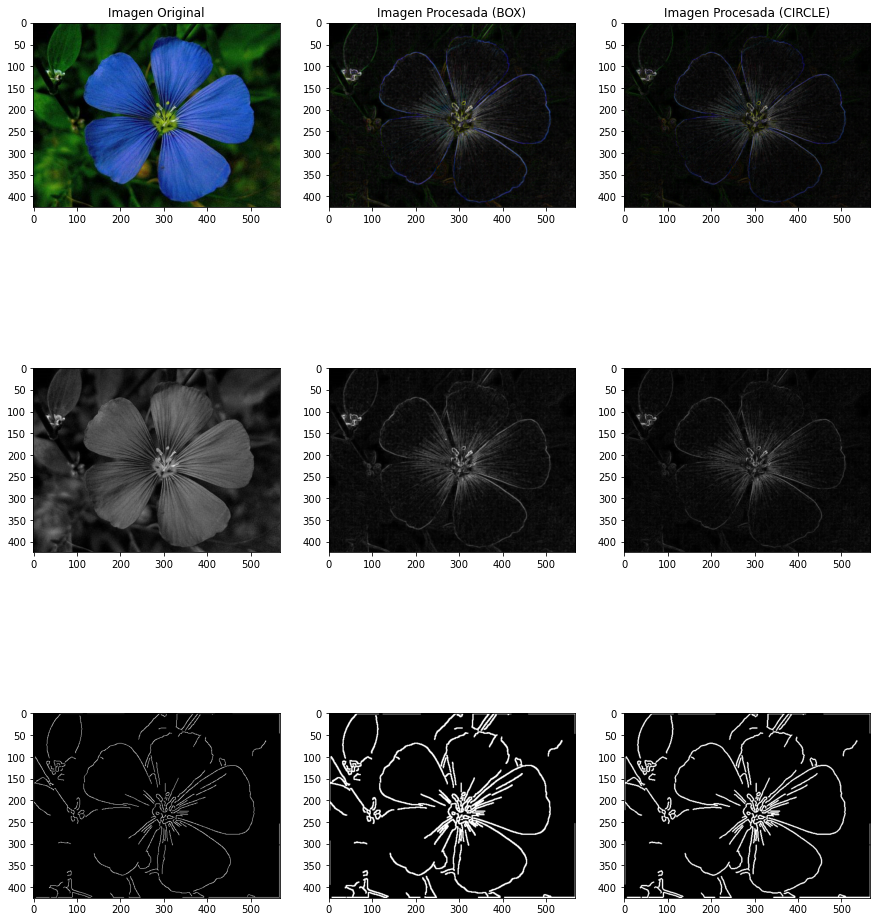

In [13]:

#Llamado a funcion gradiente con el elemento estructural box
gray_gr = gradiente(img_gray,se_box)
bin_gr = gradiente(img_bin,se_box)
rgb_gr = gradiente(img_rgb,se_box)

#Llamado a funcion gradiente con el elemento estructural circle
gray_gr_c = gradiente(img_gray,se_circle)
bin_gr_c = gradiente(img_bin,se_circle)
rgb_gr_c = gradiente(img_rgb,se_circle)

#graficos aplicando gradiente
fig, axes = plt.subplots(3, 3, figsize=(15,18))
axes[0,0].set_title('Imagen Original')
axes[0,1].set_title('Imagen Procesada (BOX)')
axes[0,2].set_title('Imagen Procesada (CIRCLE)')
axes[0,0].imshow(img_rgb)
axes[0,1].imshow(rgb_gr)
axes[0,2].imshow(rgb_gr_c)
axes[1,0].imshow(img_gray, 'gray')
axes[1,1].imshow(gray_gr, 'gray')
axes[1,2].imshow(gray_gr_c, 'gray')
axes[2,0].imshow(img_bin, 'gray')
axes[2,1].imshow(bin_gr, 'gray')
axes[2,2].imshow(bin_gr_c, 'gray')

APERTURA

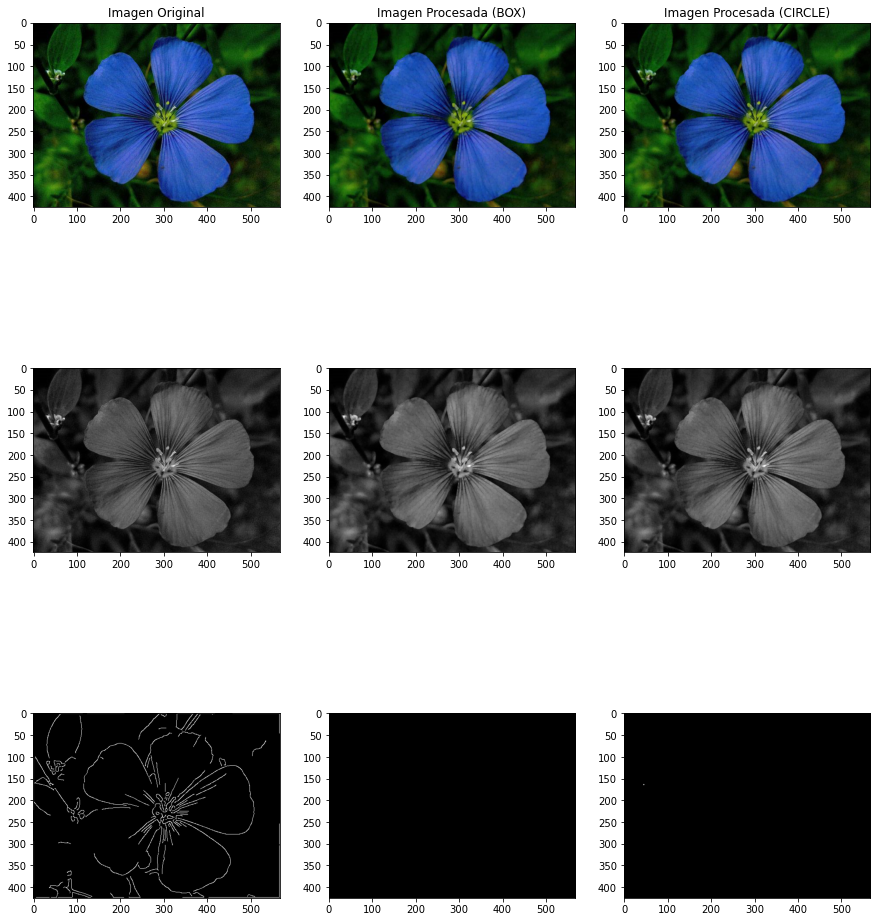

In [14]:

#Llamado a funcion apertura con el elemento estructural box
gray_ap = apertura(img_gray,se_box)
bin_ap = apertura(img_bin,se_box)
rgb_ap = apertura(img_rgb,se_box)

#Llamado a funcion apertura con el elemento estructural circle
gray_ap_c = apertura(img_gray,se_circle)
bin_ap_c = apertura(img_bin,se_circle)
rgb_ap_c = apertura(img_rgb,se_circle)

#graficos aplicando apertura
fig, axes = plt.subplots(3, 3, figsize=(15,18))
axes[0,0].set_title('Imagen Original')
axes[0,1].set_title('Imagen Procesada (BOX)')
axes[0,2].set_title('Imagen Procesada (CIRCLE)')
axes[0,0].imshow(img_rgb)
axes[0,1].imshow(rgb_ap)
axes[0,2].imshow(rgb_ap_c)
axes[1,0].imshow(img_gray, 'gray')
axes[1,1].imshow(gray_ap, 'gray')
axes[1,2].imshow(gray_ap_c, 'gray')
axes[2,0].imshow(img_bin, 'gray')
axes[2,1].imshow(bin_ap, 'gray')
axes[2,2].imshow(bin_ap_c, 'gray')

CIERRE

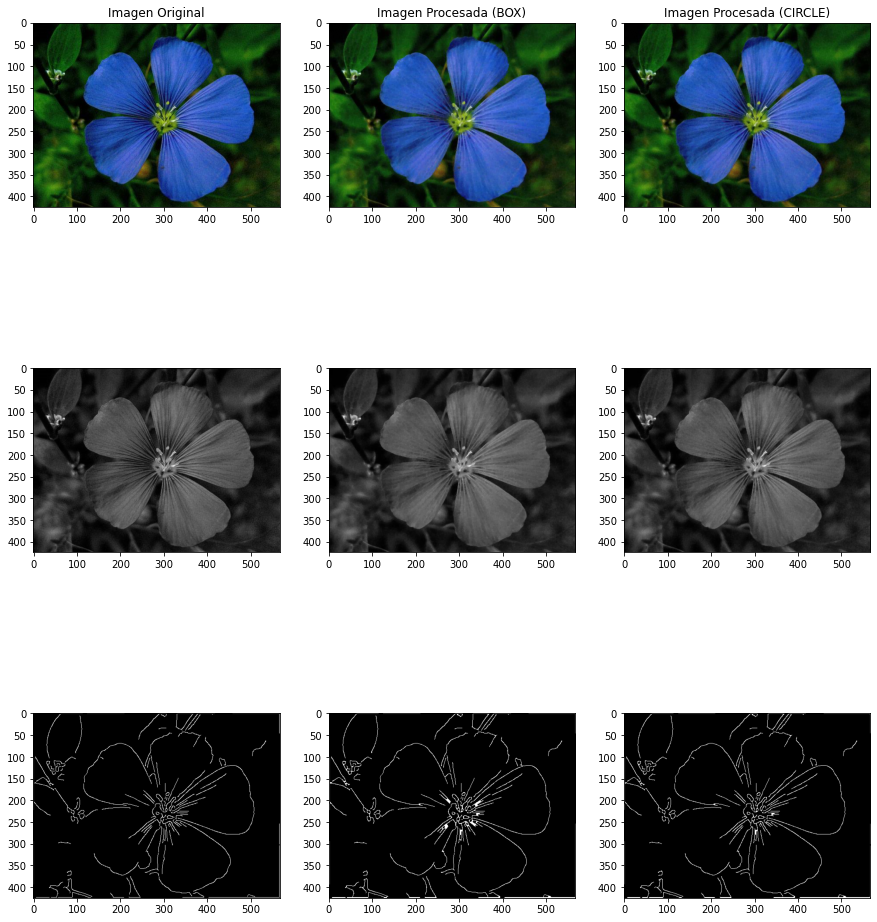

In [15]:

#Llamado a funcion cierre con el elemento estructural box
gray_ci = cierre(img_gray,se_box)
bin_ci = cierre(img_bin,se_box)
rgb_ci = cierre(img_rgb,se_box)

#Llamado a funcion cierre con el elemento estructural circle
gray_ci_c = cierre(img_gray,se_circle)
bin_ci_c = cierre(img_bin,se_circle)
rgb_ci_c = cierre(img_rgb,se_circle)

#graficos aplicando cierre
fig, axes = plt.subplots(3, 3, figsize=(15,18))
axes[0,0].set_title('Imagen Original')
axes[0,1].set_title('Imagen Procesada (BOX)')
axes[0,2].set_title('Imagen Procesada (CIRCLE)')
axes[0,0].imshow(img_rgb)
axes[0,1].imshow(rgb_ci)
axes[0,2].imshow(rgb_ci_c)
axes[1,0].imshow(img_gray, 'gray')
axes[1,1].imshow(gray_ci, 'gray')
axes[1,2].imshow(gray_ci_c, 'gray')
axes[2,0].imshow(img_bin, 'gray')
axes[2,1].imshow(bin_ci, 'gray')
axes[2,2].imshow(bin_ci_c, 'gray')

TOP HAT

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


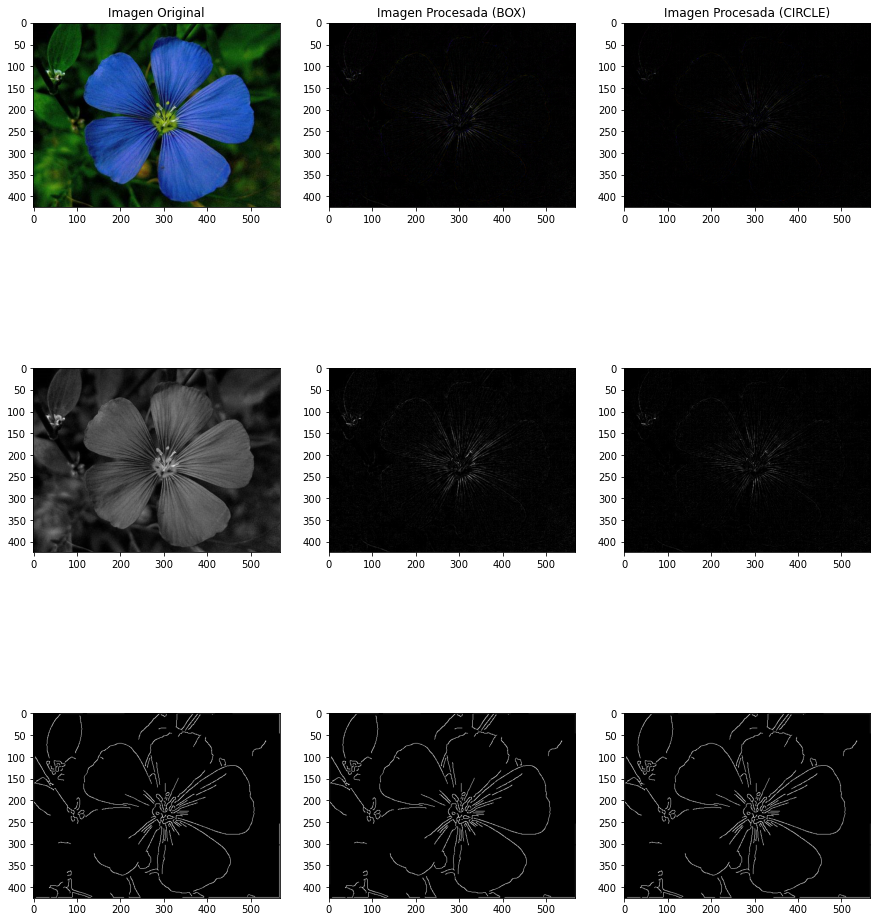

In [16]:

#Llamado a funcion top hat con el elemento estructural box
gray_top = top_hat(img_gray,se_box)
bin_top = top_hat(img_bin,se_box)
rgb_top = top_hat(img_rgb,se_box)
#Llamado a funcion top hat con el elemento estructural circle
gray_top_c = top_hat(img_gray,se_circle)
bin_top_c = top_hat(img_bin,se_circle)
rgb_top_c = top_hat(img_rgb,se_circle)

#graficos aplicando top hat
fig, axes = plt.subplots(3, 3, figsize=(15,18))
axes[0,0].set_title('Imagen Original')
axes[0,1].set_title('Imagen Procesada (BOX)')
axes[0,2].set_title('Imagen Procesada (CIRCLE)')
axes[0,0].imshow(img_rgb)
axes[0,1].imshow(rgb_top)
axes[0,2].imshow(rgb_top_c)
axes[1,0].imshow(img_gray, 'gray')
axes[1,1].imshow(gray_top, 'gray')
axes[1,2].imshow(gray_top_c, 'gray')
axes[2,0].imshow(img_bin, 'gray')
axes[2,1].imshow(bin_top, 'gray')
axes[2,2].imshow(bin_top_c, 'gray')

BOTTOM HAT

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


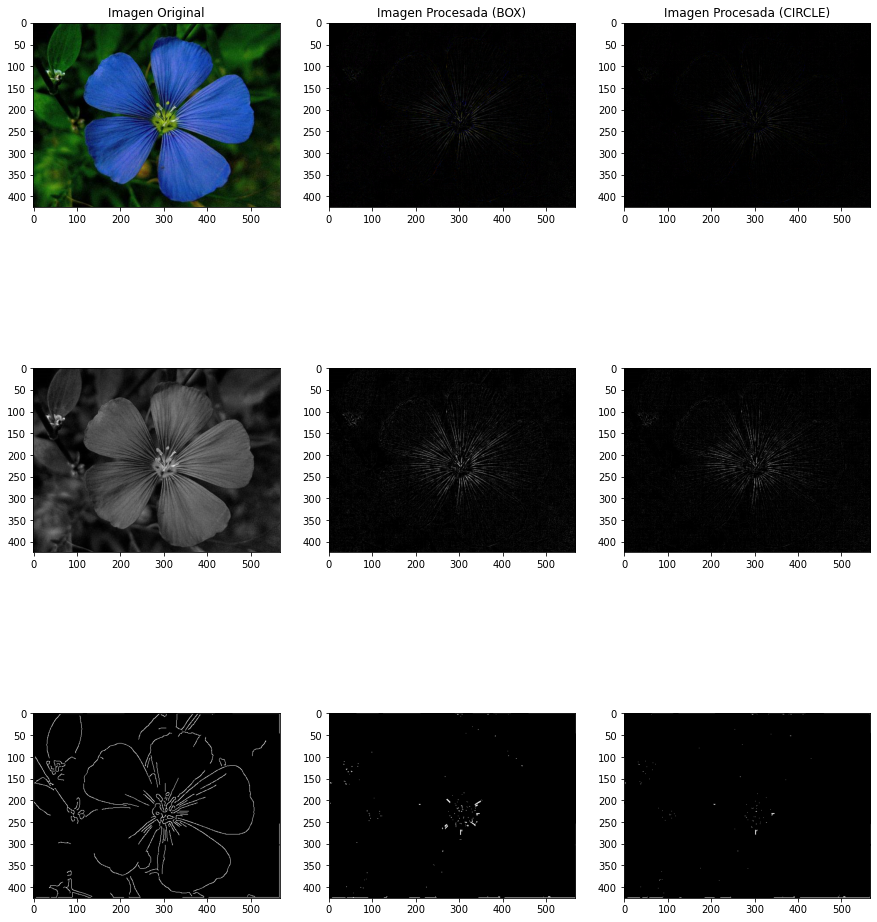

In [17]:

#Llamado a funcion bottom hat con el elemento estructural box
gray_bottom = bottom_hat(img_gray,se_box)
bin_bottom = bottom_hat(img_bin,se_box)
rgb_bottom = bottom_hat(img_rgb,se_box)

#Llamado a funcion bottom hat con el elemento estructural circle
gray_bottom_c = bottom_hat(img_gray,se_circle)
bin_bottom_c = bottom_hat(img_bin,se_circle)
rgb_bottom_c = bottom_hat(img_rgb,se_circle)

#graficos aplicando bottom hat
fig, axes = plt.subplots(3, 3, figsize=(15,18))
axes[0,0].set_title('Imagen Original')
axes[0,1].set_title('Imagen Procesada (BOX)')
axes[0,2].set_title('Imagen Procesada (CIRCLE)')
axes[0,0].imshow(img_rgb)
axes[0,1].imshow(rgb_bottom)
axes[0,2].imshow(rgb_bottom_c)
axes[1,0].imshow(img_gray, 'gray')
axes[1,1].imshow(gray_bottom, 'gray')
axes[1,2].imshow(gray_bottom_c, 'gray')
axes[2,0].imshow(img_bin, 'gray')
axes[2,1].imshow(bin_bottom, 'gray')
axes[2,2].imshow(bin_bottom_c, 'gray')

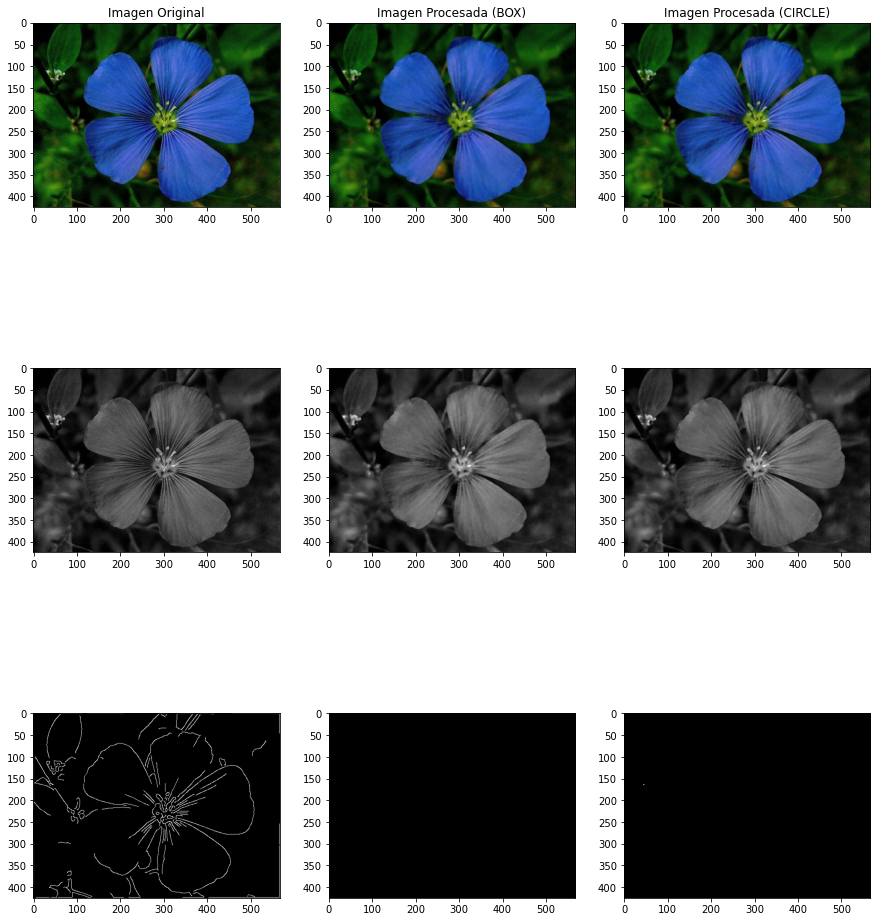

In [18]:

#Llamado a funcion open-close con el elemento estructural box
gray_oc = OC(img_gray,se_box)
bin_oc = OC(img_bin,se_box)
rgb_oc = OC(img_rgb,se_box)

#Llamado a funcion open-close con el elemento estructural circle
gray_oc_c = OC(img_gray,se_circle)
bin_oc_c = OC(img_bin,se_circle)
rgb_oc_c = OC(img_rgb,se_circle)

#graficos aplicando open-close
fig, axes = plt.subplots(3, 3, figsize=(15,18))
axes[0,0].set_title('Imagen Original')
axes[0,1].set_title('Imagen Procesada (BOX)')
axes[0,2].set_title('Imagen Procesada (CIRCLE)')
axes[0,0].imshow(img_rgb)
axes[0,1].imshow(rgb_oc)
axes[0,2].imshow(rgb_oc_c)
axes[1,0].imshow(img_gray, 'gray')
axes[1,1].imshow(gray_oc, 'gray')
axes[1,2].imshow(gray_oc_c, 'gray')
axes[2,0].imshow(img_bin, 'gray')
axes[2,1].imshow(bin_oc, 'gray')
axes[2,2].imshow(bin_oc_c, 'gray')

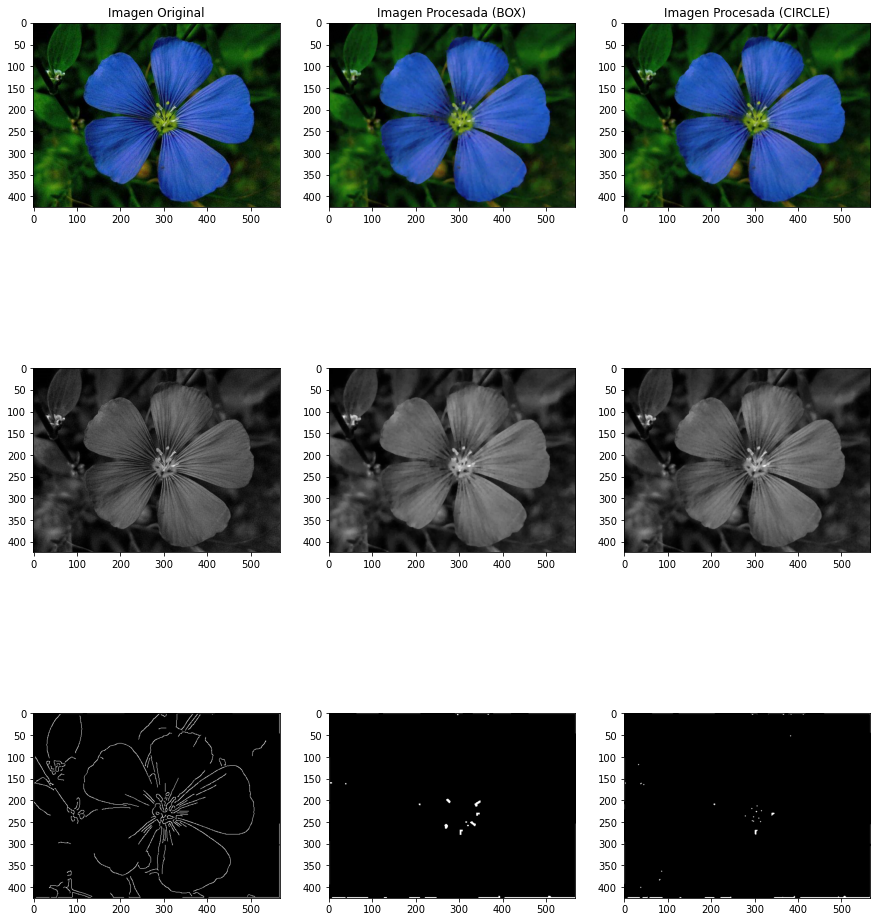

In [19]:

#Llamado a funcion close-open con el elemento estructural box
gray_co = CO(img_gray,se_box)
bin_co = CO(img_bin,se_box)
rgb_co = CO(img_rgb,se_box)

#Llamado a funcion close-open con el elemento estructural circle
gray_co_c = CO(img_gray,se_circle)
bin_co_c = CO(img_bin,se_circle)
rgb_co_c = CO(img_rgb,se_circle)

#graficos aplicando close-open
fig, axes = plt.subplots(3, 3, figsize=(15,18))
axes[0,0].set_title('Imagen Original')
axes[0,1].set_title('Imagen Procesada (BOX)')
axes[0,2].set_title('Imagen Procesada (CIRCLE)')
axes[0,0].imshow(img_rgb)
axes[0,1].imshow(rgb_co)
axes[0,2].imshow(rgb_co_c)
axes[1,0].imshow(img_gray, 'gray')
axes[1,1].imshow(gray_co, 'gray')
axes[1,2].imshow(gray_co_c, 'gray')
axes[2,0].imshow(img_bin, 'gray')
axes[2,1].imshow(bin_co, 'gray')
axes[2,2].imshow(bin_co_c, 'gray')